In [1]:
### READ RESULTS INTO PANDAS DATAFRAME
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

resultsdir = "../../../ae-results"
# list all directories in resultsdir
configs = [d for d in os.listdir(resultsdir) if os.path.isdir(os.path.join(resultsdir, d))]

configs = ['Baseline.yaml', 
            'CoMeT1000-1.yaml',
            'CoMeT1000-2.yaml',
            'CoMeT1000-3.yaml',
            'CoMeT1000-4.yaml',
            'CoMeT1000-5.yaml',
            'CoMeT500-1.yaml',
            'CoMeT500-2.yaml',
            'CoMeT500-3.yaml',
            'CoMeT500-4.yaml',
            'CoMeT500-5.yaml',
            'CoMeT250-1.yaml',
            'CoMeT250-2.yaml',
            'CoMeT250-3.yaml',
            'CoMeT250-4.yaml',
            'CoMeT250-5.yaml',
            'CoMeT125-1.yaml',
            'CoMeT125-2.yaml',
            'CoMeT125-3.yaml',
            'CoMeT125-4.yaml',
            'CoMeT125-5.yaml',
              ]
#configs = ['Baseline.yaml', 'CMS1000-100.yaml', 'Graphene1000.yaml', 'CMS1000-100-c.yaml']
# print found configs
print('Found configs: {}'.format(configs))
# list all directories under all configs
workloads = []
for c in configs:
    workloads.append([d for d in os.listdir(os.path.join(resultsdir, c)) if os.path.isdir(os.path.join(resultsdir, c, d))])
# find only the intersection of all workloads
workloads = list(set.intersection(*map(set, workloads)))
# print found workloads
print('Found workloads: {}'.format(workloads))

stats_per_config_workload = []

# for every config + workload directory
for c in configs:
    for w in workloads:
        # find all files in the directory
        files = [f for f in os.listdir(os.path.join(resultsdir, c, w)) if os.path.isfile(os.path.join(resultsdir, c, w, f))]
        # find the stats file
        stat_files = [f for f in files if f.endswith('.stats')]
        # if there is a stats file
        if stat_files:
            for stat_file in stat_files:
                # if the stats_file has less than three lines skip it
                if len(open(os.path.join(resultsdir, c, w, stat_file)).readlines()) < 3:
                    continue
                
                # print the name of the stats_file
                print('Found stats file: {}'.format(os.path.join(os.path.join(resultsdir, c, w, stat_file))))

                extension = ''
                # if stats_file file name itself does not start with DDR4, parse it a bit
                if not stat_file.startswith('DDR4'):
                    # get the config name from the stats_file name
                    extension = '_'.join(stat_file.split('_')[:-1])
                    # prepend underscore to extension
                    extension = '_' + extension

                # read the stats file, name columns: 'name', 'value', 'description'
                df = pd.read_csv(os.path.join(resultsdir, c, w, stat_file), header=None).T
                df.columns = df.iloc[0]
                df.drop(0,inplace=True)
                # add a new column called 'config' with the config name
                df['config'] = c + extension
                # add a new column called 'workload' with the workload name
                df['workload'] = w
                # print the stats file
                # print('Config: {}, Workload: {}, Stats: {}'.format(c, w, df))
                # append the stats to the list
                df.reset_index(inplace=True, drop=True)
                stats_per_config_workload.append(df)
        else:
            print('Config: {}, Workload: {}, Stats: No stats file found'.format(c, w))

# concatenate all stats into one dataframe
stats = pd.concat(stats_per_config_workload)

# find elements where workload does not contain '-'
# these are multi core workloads
stats = stats[~stats['workload'].str.contains('-')]

# remove these two workloads: stream_10.trace and random_10.trace
stats = stats[~stats['workload'].isin(['stream10_200.trace', 'random10_200.trace'])]
# also from workloads
workloads = [w for w in workloads if not w in ['stream10_200', 'random10_200.trace']]

#remove configs that has RH32, AH and AAH in the name
stats = stats[~stats['config'].str.contains('RH32')]
stats = stats[~stats['config'].str.contains('AH')]
stats = stats[~stats['config'].str.contains('AAH')]

# remove "-16DR" from config names
stats['config'] = stats['config'].str.replace('-16DR', '')

# replace 1K with 1000 in config names
stats['config'] = stats['config'].str.replace('1K', '1000')

# replace 'Baseline' with 'Baseline0'
stats['config'] = stats['config'].str.replace('Baseline', 'Baseline0')

# add a new column that stores in integer the number in the config name
stats['nrh'] = stats['config'].str.extract('(\d+)').astype(int)

# remove numbers from config names
stats['config'] = stats['config'].str.replace('\d+', '')

# remove yaml from config names
stats['config'] = stats['config'].str.replace('.yaml', '')

# increasing order of rbmpki
# order = ['511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', '500.perlbench', '523.xalancbmk', '510.parest', '557.xz', '482.sphinx3', '505.mcf', '436.cactusADM', '471.omnetpp', '473.astar', '483.xalancbmk', '462.libquantum', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf']
#order = ['h264_encode', '511.povray', '481.wrf', '541.leela', '538.imagick', '444.namd', '447.dealII', '464.h264ref', '456.hmmer', '403.gcc', '526.blender', '544.nab', '525.x264', '508.namd', 'grep_map0', '531.deepsjeng', '458.sjeng', '435.gromacs', '445.gobmk', '401.bzip2', '507.cactuBSSN', '502.gcc', 'ycsb_abgsave', 'tpch6', '500.perlbench', '523.xalancbmk', 'ycsb_dserver', 'ycsb_cserver', '510.parest', 'ycsb_bserver', 'ycsb_eserver', 'stream_10.trace', 'tpcc64', 'ycsb_aserver', '557.xz', '482.sphinx3', 'jp2_decode', '505.mcf', 'wc_8443', 'wc_map0', '436.cactusADM', '471.omnetpp', '473.astar', 'jp2_encode', 'tpch17', '483.xalancbmk', '462.libquantum', 'tpch2', '433.milc', '520.omnetpp', '437.leslie3d', '450.soplex', '459.GemsFDTD', '549.fotonik3d', '434.zeusmp', '519.lbm', '470.lbm', '429.mcf', 'random_10.trace', 'h264_decode', 'bfs_ny', 'bfs_cm2003', 'bfs_dblp']

#order =  [
#   'random10_200m.trace',
#   'stream10_200m.trace',
#   '401.bzip2',
#   '403.gcc',
#   '429.mcf',
#   '433.milc',
#   '434.zeusmp',
#   '435.gromacs',
#   '436.cactusADM',
#   '462.libquantum',
#   '470.lbm',
#   '483.xalancbmk'
#]

# order workloads according to the order
#stats['workload'] = pd.Categorical(stats['workload'], categories=order, ordered=True)
#stats['workload'] = pd.Categorical(stats['workload'])

stats_copy = stats.copy()

# use seaborn-deep style
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_palette("pastel", n_colors=4)

stats = stats_copy.copy()



# instructions per cycle (IPC) is record_cycles_insts_0 / record_cycs_core_0
stats['ramulator.ipc'] = stats['ramulator.record_insts_core_0'] / stats['ramulator.record_cycs_core_0']


stats['ramulator.rbmpki'] = (stats['ramulator.row_conflicts_channel_0_core'] + stats['ramulator.row_misses_channel_0_core']) /\
                            stats['ramulator.record_insts_core_0'] * 1000


# copy the IPC of the baseline config as to all configs
baseline = stats[stats['config'] == 'Baseline0']
baseline = baseline[['workload', 'ramulator.ipc', 'ramulator.read_latency_avg_0', 'ramulator.rbmpki', 'ramulator.window_full_stall_cycles_core_0']]
# baseline
baseline.columns = ['workload', 'ramulator.baseline_ipc', 'ramulator.baseline_read_latency_avg_0', 'ramulator.baseline_rbmpki', 'ramulator.baseline_stall_cycles']
print('baseline:')
print(baseline)

stats = pd.merge(stats, baseline, on='workload')


#hydra baseline
# hydra_baseline = stats[stats['config'] == 'Hydra-Baseline']
# hydra_baseline = hydra_baseline[['workload', 'ramulator.ipc']]
# # hydra_baseline
# hydra_baseline.columns = ['workload', 'ramulator.hydra_baseline_ipc']
# stats = pd.merge(stats, hydra_baseline, on='workload')

stats['ramulator.normalized_ipc'] = stats['ramulator.ipc'] / stats['ramulator.baseline_ipc']
stats['ramulator.normalized_read_latency'] = stats['ramulator.read_latency_avg_0'] / stats['ramulator.baseline_read_latency_avg_0']
stats['ramulator.normalized_stall_cycles'] = stats['ramulator.window_full_stall_cycles_core_0'] / stats['ramulator.baseline_stall_cycles']
stats['ramulator.normalized_rbmpki'] = stats['ramulator.rbmpki'] / stats['ramulator.baseline_rbmpki']


# normalized ipc for hydra is not correct, so we overwrite it with the correct value
# stats.loc[stats['config'].str.contains('Hydra'), 'ramulator.normalized_ipc'] = stats['ramulator.ipc'] / stats['ramulator.hydra_baseline_ipc']

# add the geometric normalized ipc average as a new workload to every config
geometric_mean = stats.groupby(['config','nrh'])['ramulator.normalized_ipc'].apply(lambda x: x.prod()**(1.0/len(x))).reset_index()
geometric_mean['workload'] = 'GeoMean'

#print(stats['config'])


stats = pd.concat([stats, geometric_mean])
print(stats['config'])
print(stats['workload'])
# print data with workload = GeoMean
print(stats[stats['workload'] == 'GeoMean'])

Found configs: ['Baseline.yaml', 'CoMeT1000-1.yaml', 'CoMeT1000-2.yaml', 'CoMeT1000-3.yaml', 'CoMeT1000-4.yaml', 'CoMeT1000-5.yaml', 'CoMeT500-1.yaml', 'CoMeT500-2.yaml', 'CoMeT500-3.yaml', 'CoMeT500-4.yaml', 'CoMeT500-5.yaml', 'CoMeT250-1.yaml', 'CoMeT250-2.yaml', 'CoMeT250-3.yaml', 'CoMeT250-4.yaml', 'CoMeT250-5.yaml', 'CoMeT125-1.yaml', 'CoMeT125-2.yaml', 'CoMeT125-3.yaml', 'CoMeT125-4.yaml', 'CoMeT125-5.yaml']
Found workloads: ['436.cactusADM', '523.xalancbmk', '483.xalancbmk', 'tpch2', 'h264_encode', '444.namd', '473.astar', '401.bzip2', 'jp2_encode', 'bfs_cm2003', '541.leela', '538.imagick', '519.lbm', '526.blender', '445.gobmk', '435.gromacs', '510.parest', '456.hmmer', '511.povray', '429.mcf', '500.perlbench', 'grep_map0', 'ycsb_eserver', 'ycsb_abgsave', '459.GemsFDTD', '507.cactuBSSN', 'bfs_dblp', 'tpch17', 'wc_map0', 'h264_decode', '482.sphinx3', 'tpch6', 'ycsb_bserver', 'wc_8443', '508.namd', '437.leslie3d', '505.mcf', '450.soplex', '433.milc', '531.deepsjeng', '403.gcc', '4

In [2]:
stats_clean = stats.copy()
print(stats_clean['config'].unique())
print(stats_clean['nrh'].unique())
# change CMS125-4-512-128 to CMS125 in config

['Baseline0' 'CoMeT1000-1' 'CoMeT1000-2' 'CoMeT1000-3' 'CoMeT1000-4'
 'CoMeT1000-5' 'CoMeT500-1' 'CoMeT500-2' 'CoMeT500-3' 'CoMeT500-4'
 'CoMeT500-5' 'CoMeT250-1' 'CoMeT250-2' 'CoMeT250-3' 'CoMeT250-4'
 'CoMeT250-5' 'CoMeT125-1' 'CoMeT125-2' 'CoMeT125-3' 'CoMeT125-4'
 'CoMeT125-5']
[   0 1000  500  250  125]


In [3]:
import re

sns.set(font_scale=1.0)
sns.set_style("whitegrid")
#sns.set_palette("viridis", n_colors=5)

# sns set color palette
comet_palette = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
sns.set_palette(comet_palette, n_colors=5)

stats = stats_clean.copy()
# remove random10_200m.trace and stream10_200m.trace
stats = stats[~stats['workload'].isin(['random10_200m.trace', 'stream10_200m.trace'])]

# drop all configs except the ones with CMS 
stats_no_baseline = stats[stats['config'].str.contains('CoMeT')]
stats_comparison = stats[~stats['config'].str.contains('CoMeT')]
# remove oracle from stats_comparison

print(stats_comparison['config'].unique())

# merge stats_comparison and stats_no_baseline
stats_new = pd.concat([stats_comparison, stats_no_baseline])

# remove config Baseline0 from stats_no_baseline
stats_new = stats_new[~stats_new['config'].str.contains('Baseline0')]
print(stats_new['config'].unique())


['Baseline0']
['CoMeT1000-1' 'CoMeT1000-2' 'CoMeT1000-3' 'CoMeT1000-4' 'CoMeT1000-5'
 'CoMeT500-1' 'CoMeT500-2' 'CoMeT500-3' 'CoMeT500-4' 'CoMeT500-5'
 'CoMeT250-1' 'CoMeT250-2' 'CoMeT250-3' 'CoMeT250-4' 'CoMeT250-5'
 'CoMeT125-1' 'CoMeT125-2' 'CoMeT125-3' 'CoMeT125-4' 'CoMeT125-5']


['CoMeT-1' 'CoMeT-2' 'CoMeT-3' 'CoMeT-4' 'CoMeT-5']
['k=1' 'k=2' 'k=3' 'k=4' 'k=5']


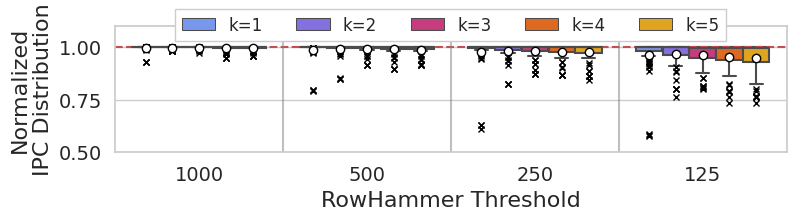

In [4]:

# remove nrh 64 and 32 from stats

# order nRH from high to low
#stats_no_baseline['counters'] = pd.Categorical(stats_no_baseline['counters'], categories=[128], ordered=True)
#
#stats_no_baseline['hashes'] = pd.Categorical(stats_no_baseline['hashes'], categories=[4], ordered=True)
#
#stats_no_baseline['entries'] = pd.Categorical(stats_no_baseline['entries'], categories=[32,64,128,256,512], ordered=True)
stats_new['nrh'] = pd.Categorical(stats_new['nrh'], categories=[1000,500,250,125], ordered=True)

#change COMET1000 to COMET 
stats_new['config'] = stats_new['config'].str.replace('CoMeT1000', 'CoMeT')
stats_new['config'] = stats_new['config'].str.replace('CoMeT500', 'CoMeT')
stats_new['config'] = stats_new['config'].str.replace('CoMeT250', 'CoMeT')
stats_new['config'] = stats_new['config'].str.replace('CoMeT125', 'CoMeT')

print(stats_new['config'].unique())

# rename config COMET COMET-n2
stats_new['config'] = stats_new['config'].str.replace('CoMeT-1', 'k=1')
stats_new['config'] = stats_new['config'].str.replace('CoMeT-2', 'k=2')
stats_new['config'] = stats_new['config'].str.replace('CoMeT-3', 'k=3')
stats_new['config'] = stats_new['config'].str.replace('CoMeT-4', 'k=4')
stats_new['config'] = stats_new['config'].str.replace('CoMeT-5', 'k=5')

print(stats_new['config'].unique())


# order config in this order: CMS, Graphene
stats_new['config'] = pd.Categorical(stats_new['config'], categories=['k=1','k=2','k=3','k=4', 'k=5'], ordered=True)

#boxplot of normalized IPC

# create two subplots
fig, ax = plt.subplots(figsize=(8, 2.5))



# show mean values as well
ax = sns.boxplot(x="nrh", y="ramulator.normalized_ipc", hue="config", data=stats_new, showmeans=True,
                  meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, showfliers=True, 
                  flierprops={'marker': 'x', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
ax.set_xlabel('RowHammer Threshold')
ax.set_ylabel('Normalized\nIPC Distribution')
# draw a red line at y = 1.0, label it as baseline IPC
ax.axhline(y=1.0, color='r', linestyle='--')
# write above the red line 'baseline IPC'
#ax.text(0.02, 0.93, 'baseline IPC', color='#e74c3c', transform=ax.transAxes, fontsize=15)
# extend the y axis to 1.2
ax.set_ylim(0.5, 1.1)
# color the 5th y tick red
#ax.get_yticklabels()[4].set_color('#e74c3c')
# make axis tick font bigger
ax.tick_params(axis='both', which='major', labelsize=14)
# draw vertical lines to separate the rowhammer threshold values
# make x and y axis labels bigger
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

# Customize the whiskers and borders
ax.lines[0].set_color('black')  # Set the color of the whiskers\

ax.axvline(x=0.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=1.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=2.5, color='grey', linestyle='-', alpha=0.5)


# put the legend on top of the plot
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fancybox=True, shadow=True, fontsize=12)
# add legend title as "counters per hash"
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fancybox=False, shadow=False, fontsize=12, framealpha=1)

plt.tight_layout()
plt.show()

# save figure
fig.savefig('singlecore-comparison.pdf', bbox_inches='tight')
# export data to csv
stats_no_baseline.to_csv('comet-singlecore-comparison.csv', index=False)

# list mean normalized_ipc at 1000 nRH for all configs
#print(stats_no_baseline.groupby(['config','nrh'])['ramulator.normalized_ipc'].mean())

In [5]:
print(stats_clean.groupby(['config','nrh'])['ramulator.normalized_ipc'].min())
print(stats_clean.groupby(['config','nrh'])['ramulator.normalized_ipc'].mean())

# create stats summary with 'config','nrh','ramulator.normalized_ipc', 'ramulator.normalized_read_latency', 'ramulator.normalized_stall_cycles', 'ramulator.normalized_rbmpki', 'ramulator.preventivepreventive_refreshes_channel_0_core'
stats_summary = stats_clean[['config','nrh','workload','ramulator.normalized_ipc', 
'ramulator.normalized_read_latency', 'ramulator.normalized_stall_cycles', 'ramulator.normalized_rbmpki', 
'ramulator.preventive_refreshes_channel_0_core']].copy()

# stats_summary to csv
stats_summary.to_csv('comet-singlecore-summary-ksweep.csv', index=False)

config       nrh 
Baseline0    0            1.0
CoMeT1000-1  1000    0.927374
CoMeT1000-2  1000    0.979902
CoMeT1000-3  1000    0.973512
CoMeT1000-4  1000    0.947863
CoMeT1000-5  1000    0.959177
CoMeT125-1   125     0.576249
CoMeT125-2   125     0.761039
CoMeT125-3   125     0.801787
CoMeT125-4   125     0.735022
CoMeT125-5   125     0.733565
CoMeT250-1   250     0.610597
CoMeT250-2   250      0.82251
CoMeT250-3   250     0.871686
CoMeT250-4   250      0.86596
CoMeT250-5   250     0.845775
CoMeT500-1   500     0.791668
CoMeT500-2   500     0.850452
CoMeT500-3   500     0.914992
CoMeT500-4   500     0.898216
CoMeT500-5   500     0.913855
Name: ramulator.normalized_ipc, dtype: object
config       nrh 
Baseline0    0            1.0
CoMeT1000-1  1000     0.99609
CoMeT1000-2  1000    0.998008
CoMeT1000-3  1000    0.998108
CoMeT1000-4  1000    0.995489
CoMeT1000-5  1000    0.995578
CoMeT125-1   125     0.964945
CoMeT125-2   125     0.966849
CoMeT125-3   125     0.961813
CoMeT125-4   125  

In [6]:
# print the number of workloads per config
print(stats_summary.groupby(['config'])['workload'].count())

config
Baseline0      62
CoMeT1000-1    62
CoMeT1000-2    62
CoMeT1000-3    62
CoMeT1000-4    62
CoMeT1000-5    62
CoMeT125-1     62
CoMeT125-2     62
CoMeT125-3     62
CoMeT125-4     62
CoMeT125-5     62
CoMeT250-1     62
CoMeT250-2     62
CoMeT250-3     62
CoMeT250-4     62
CoMeT250-5     62
CoMeT500-1     62
CoMeT500-2     62
CoMeT500-3     62
CoMeT500-4     62
CoMeT500-5     62
Name: workload, dtype: int64
